**Machine Learning for prediction of the RMSD (Root Mean Square Deviation) of a decoy set using Physicochemical Properties of Protein Tertiary Structure Data Set**

The workflow followed here is adapted from the book [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://g.co/kgs/bvvihi) by **Aurélien Geron**.

**Scope of this work* : To layout the Machine Learning workflow from start to end. 

*Requirements* : ScikitLearn, Numpy, Matplotlib and Pandas

*The dataset is downloaded from this link [Physicochemical Properties of Protein Tertiary Structure Data Set](https://archive.ics.uci.edu/ml/datasets/Physicochemical+Properties+of+Protein+Tertiary+Structure).* 

*This notebook is divided into two sections:*
1. **Data preprocessing** *- Explore the dataset and prepare it before regression*
2. **Model selection, training and fine tuning** *- Try with various models, compare their performance and fine tune them*

# 1. Data Preprocessing

Load all the relevant modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
plt.style.use('default')
%matplotlib inline

Download the dataset from UCI website and load using Pandas. In case the data exists already, load it directly without downloading

In [2]:
import requests, os

if os.path.exists("./CASP.csv") is False:
    r = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/00265/CASP.csv", allow_redirects=True)
    open("CASP.csv", 'wb').write(r.content)
casp = pd.read_csv("CASP.csv")
casp.head()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147


Attributes Information:

* RMSD-Size of the residue. 
* F1 - Total surface area. 
* F2 - Non polar exposed area. 
* F3 - Fractional area of exposed non polar residue. 
* F4 - Fractional area of exposed non polar part of residue. 
* F5 - Molecular mass weighted exposed area. 
* F6 - Average deviation from standard exposed area of residue. 
* F7 - Euclidian distance. 
* F8 - Secondary structure penalty. 
* F9 - Spacial Distribution constraints (N,K Value).

Start with collecting all the useful statistics from the dataset

In [3]:
casp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45730 entries, 0 to 45729
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RMSD    45730 non-null  float64
 1   F1      45730 non-null  float64
 2   F2      45730 non-null  float64
 3   F3      45730 non-null  float64
 4   F4      45730 non-null  float64
 5   F5      45730 non-null  float64
 6   F6      45730 non-null  float64
 7   F7      45730 non-null  float64
 8   F8      45730 non-null  int64  
 9   F9      45730 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 3.5 MB


In [4]:
casp.describe()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
count,45730.000000,45730.000000,45730.000000,45730.000000,45730.000000,4.573000e+04,45730.000000,45730.000000,45730.000000,45730.000000
mean,7.748528,9871.596995,3017.367175,0.302392,103.492433,1.368299e+06,145.638061,3989.755990,69.975071,34.523664
std,6.118312,4058.138034,1464.324663,0.062886,55.424985,5.640367e+05,69.999230,1993.574575,56.493443,5.979755
min,0.000000,2392.050000,403.500000,0.092500,10.310100,3.194902e+05,31.970400,0.000000,0.000000,15.228000
25%,2.305000,6936.680000,1979.045000,0.258740,63.563900,9.535912e+05,94.757500,3165.322500,31.000000,30.424725
50%,5.030000,8898.805000,2668.155000,0.300150,87.740800,1.237219e+06,126.176000,3840.170000,54.000000,35.299300
75%,13.379000,12126.150000,3786.410000,0.342890,133.646750,1.690920e+06,181.468500,4644.192500,91.000000,38.870800
max,20.999000,40034.900000,15312.000000,0.577690,369.317000,5.472011e+06,598.408000,105948.170000,350.000000,55.300900


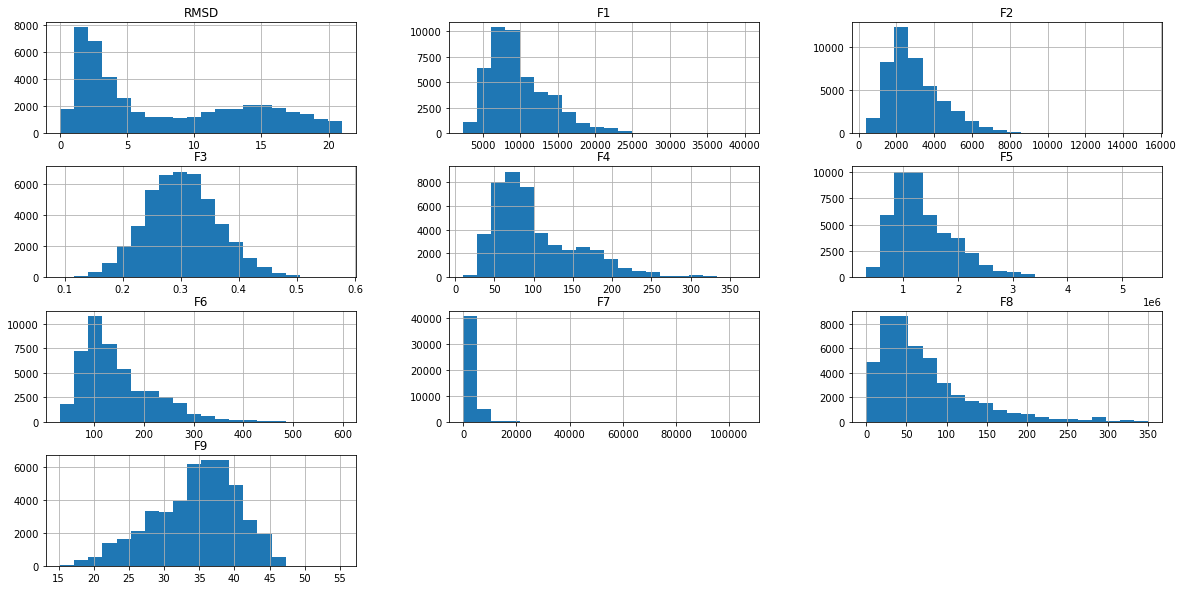

In [5]:
casp.hist(bins=20, figsize=(20,10));

One thing we notice is that, `F7` has tail heavy distribution. Let us see if there is any missing data in the dataset

In [6]:
np.any(casp.values == np.nan)

False

Generate the Standard Correlation Coefficient plot to visualize how every variable correlates with one another and at the same time with the target variable, `RMSD`

<ipython-input-7-4bacd22158af>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+list(casp));
<ipython-input-7-4bacd22158af>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+list(casp));


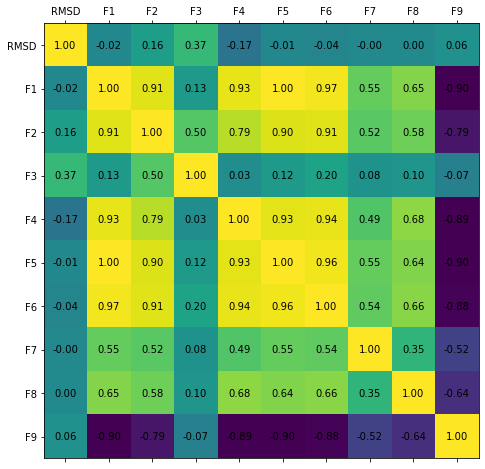

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(casp.corr(), interpolation='none')

for (i, j), value in np.ndenumerate(casp.corr()):
    plt.text(i, j, f"{value:.2f}", va="center", ha="center")

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
ax.set_xticklabels(['']+list(casp));
ax.set_yticklabels(['']+list(casp));

Sort the linear correlation coefficient for `RMSD` to check which variables are correlated most with `RMSD`

In [8]:
casp.corr()['RMSD'].sort_values(ascending=False)

RMSD    1.000000
F3      0.374309
F2      0.156895
F9      0.062830
F8      0.000344
F7     -0.003339
F5     -0.013982
F1     -0.015087
F6     -0.036135
F4     -0.169771
Name: RMSD, dtype: float64

Turns out `F3` is very strongly correlated with `RMSD`. One thing to note here, this captures purely linear correlation and misses out the non linear correlation. Another method to visualize the correlation is scatter matrix

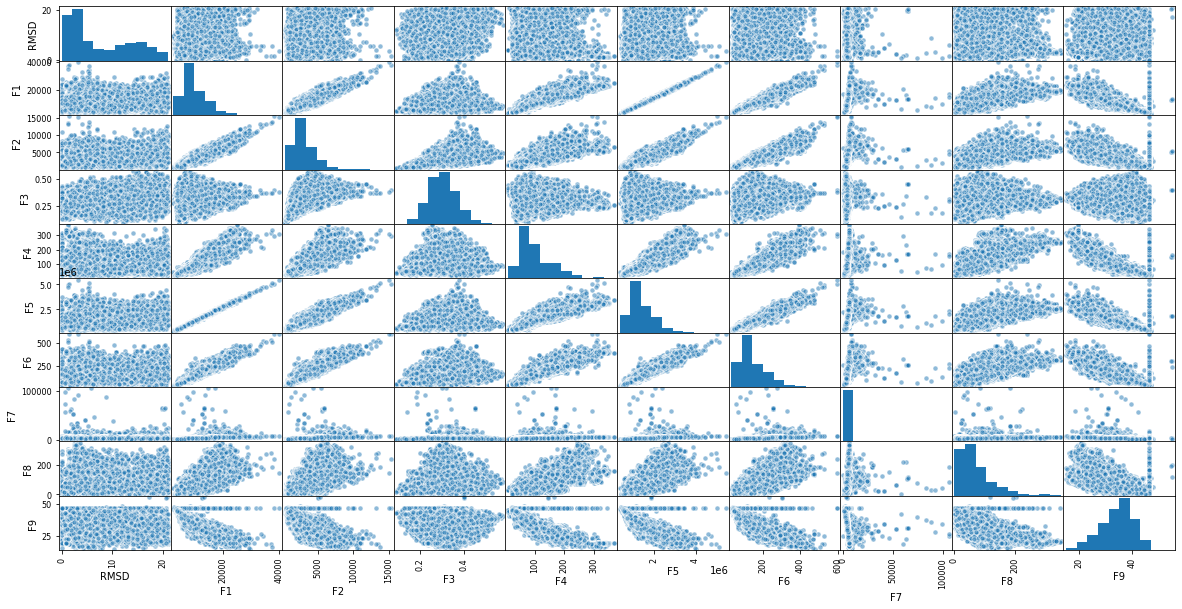

In [9]:
pd.plotting.scatter_matrix(casp, figsize=(20,10), edgecolors='w', s=100);

Some points to note from the plots above:

1. There is no strong linear correlation between independent variables and `RMSD`
2. Some of the features are very well correlated with each other. For example, `F1`, `F2`, `F4`, `F5` and `F6` seems to be correlated well. It is worthwhile to spend time in reducing the dimensionality of this data
3. From the correlations plots, let us pay more attention to feature `F9`. It can be easily noted that the values near ~50 have been capped artificially. Similarly For `RMSD`, the data is artificially capped close to 0.1. It is suggested to take a closer look at the data collection method. At this point, it is good to get rid of this data

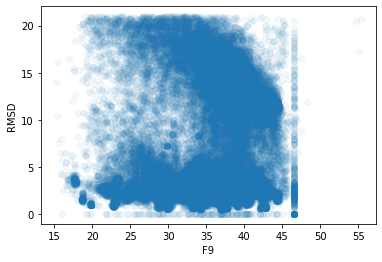

In [10]:
plt.scatter(casp["F9"], casp["RMSD"], alpha=0.05);
plt.xlabel("F9");
plt.ylabel("RMSD");

Let us for now get rid of this artificially capped data from the dataset

In [11]:
casp_cleaned = casp[casp['F9']<46]
casp_cleaned = casp_cleaned[casp_cleaned["RMSD"] > 0.1]
casp_cleaned = casp_cleaned.reset_index().drop("index", axis=1)

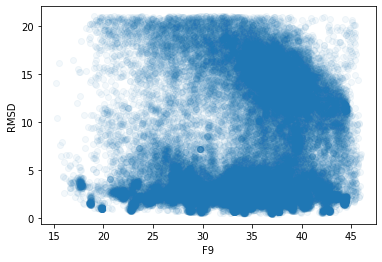

In [12]:
plt.scatter(casp_cleaned["F9"], casp_cleaned["RMSD"], alpha=0.05);
plt.xlabel("F9");
plt.ylabel("RMSD");

Seperate training set and test set from the CASP dataset. In this example, we will make use of stratified sampling for training and test set seperation. In this case, we pick `F3` for creating the categories since it correlates with `RSMD` the highest. Suppose, we are told that any other variable is important from the standpoint of retaining the same statistics for the test set as that of train set, we would use that variable to create the categories and sample the dataset from. In this case, start with having 6 categories of `F3` data

In [13]:
casp_cleaned["F3_cat"] = pd.cut(casp_cleaned["F3"], 
                                bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, np.inf],
                                labels = [1, 2, 3, 4, 5, 6])

Count the proportion of values corresponding to each category in `F3`

In [14]:
casp_cleaned["F3_cat"].value_counts()/len(casp_cleaned)

3    0.451977
4    0.435600
5    0.065732
2    0.044472
6    0.002153
1    0.000067
Name: F3_cat, dtype: float64

<AxesSubplot:>

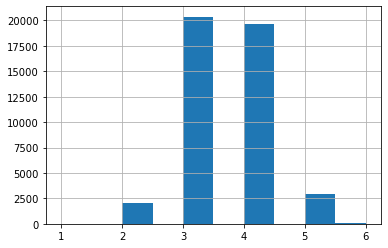

In [15]:
casp_cleaned["F3_cat"].hist()

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(casp_cleaned, casp_cleaned["F3_cat"]):
    casp_train_set = casp_cleaned.loc[train_index]
    casp_test_set = casp_cleaned.loc[test_index]

It appears that the category counts for training set of `L3` is matching with the original dataset

In [17]:
casp_train_set["F3_cat"].value_counts()/len(casp_train_set)

3    0.451968
4    0.435602
5    0.065744
2    0.044467
6    0.002164
1    0.000055
Name: F3_cat, dtype: float64

In [18]:
for set_ in (casp_train_set, casp_test_set):
    set_.drop("F3_cat", axis=1, inplace = True)

Separate the dependent and independent variables

In [19]:
X_train, y_train = casp_train_set.drop("RMSD", axis=1),casp_train_set["RMSD"]
X_test, y_test = casp_test_set.drop("RMSD", axis=1),casp_test_set["RMSD"]

As a last step, scale the variables of the input data using StandardScaler function. As we had noted earlier, the inputs are correlated with one another. Use PCA to project the inputs onto an independent bases. It will make model learning more efficient. Use 0.99 for `n_components` hyperparameter and let the algorithm find out how many number of independent bases it takes to reconstruct the inputs such that, 99% variance is recovered.

Combine these two operations using Pipeline module. Notice we will only scale the inputs, the outputs remain untouched

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipeline = Pipeline([
    ('std_scaler',StandardScaler()),
    ('pca', PCA(n_components=0.99))
])

X_train_scaled = pipeline.fit_transform(X_train)

Now the data is ready for training a machine learning model

# 2. Model selection, training and fine tuning

Start with linear regression, although we might know that this will not yield the best results, given there is no linear correlation between inputs and output. Linear regression model can be used as a good baseline model to compare other models with

### 2.1 Linear Model

In [21]:
%%time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

Wall time: 7.98 ms


LinearRegression()

In order to get a feel of how the model is performing visually, randomly pick 10 values from training set, predict the target value and plot it against the gound-truth. Encapsulte this in a function to plot the results as we will use it in multiple places

In [22]:
def plot_results(X, y, model, title_text):
    plt.figure(figsize=(5,5))
    y_pred = model.predict(X)
    plt.scatter(y_pred,y)
    plt.plot([y_pred.min(),y_pred.max()],[y.min(),y.max()],'k')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title_text)

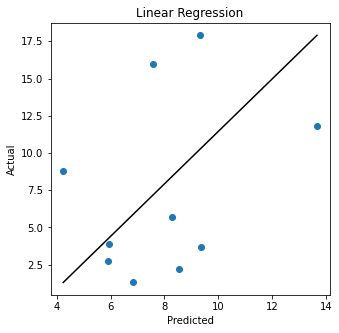

In [23]:
r = np.random.RandomState(42)
indices = r.choice(X_train_scaled.shape[0], 10)
X_selected = X_train_scaled[indices]
y_selected = y_train.values[list(indices)]

plot_results(X_selected, y_selected, lin_reg, "Linear Regression")

Use random forest regression model for this problem and see if that is better in terms of prediction accuracy. Make use of K-fold Cross Validation approach to make sure that the model is not overfitting the data

### 2.2 Random Forest Regressor

In [24]:
%%time
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(X_train_scaled, y_train);

Wall time: 19 s


RandomForestRegressor()

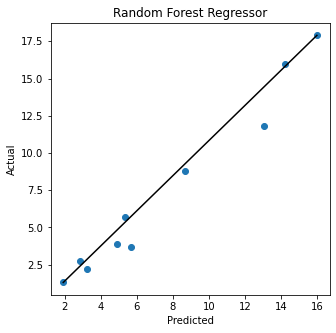

In [25]:
plot_results(X_selected, y_selected, forest_reg, "Random Forest Regressor")

Random Forest Regressor definitely works better compared to Linear Regression. The randomly sampled points from the training set lie closer to the line, indicating a small prediction error (distance indicates mean squared error - More the distance, more the error in the prediction and vice versa)

In [26]:
from sklearn.model_selection import cross_val_score
scores= cross_val_score(forest_reg, X_train_scaled, y_train, scoring = "neg_mean_squared_error", cv=5)

In [27]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [28]:
display_scores(np.sqrt(-scores))

Scores: [3.90469289 3.84780993 3.87505685 3.87347285 3.88322556]
Mean: 3.876851614699086
Standard deviation: 0.018296557249074526


The mean score for Random Forest model is 3.86 and the standard deviation is 0.01. The mean score here indicates the average (over 5 folds) of root mean square error between the model prediction and the actual outputs. Try cross validation for Linear Regression as well

In [29]:
scores= cross_val_score(lin_reg, X_train_scaled, y_train, scoring = "neg_mean_squared_error", cv=5)

In [30]:
display_scores(np.sqrt(-scores))

Scores: [5.16936473 5.12840384 5.20475787 5.17569804 5.19324947]
Mean: 5.174294788766649
Standard deviation: 0.02615161014197285


As we said earlier, Random Forest Regressor stands out in terms of accuracy.

By default, the number of estimators (one of the hyperparameters) for Random Forest is chosen as 100. Try to refine the model's hyperparameter using Grid Search method. In this particular case, Grid Search will run 4X2=8 combinations with 3 folds of input data to generate scores

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [10, 100, 150, 300]},
              {'bootstrap': [False], 'n_estimators': [10, 100, 150, 300]}]
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=3,scoring='neg_mean_squared_error',return_train_score=True)

In [32]:
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid=[{'n_estimators': [10, 100, 150, 300]},
                         {'bootstrap': [False],
                          'n_estimators': [10, 100, 150, 300]}],
             return_train_score=True, scoring='neg_mean_squared_error')

Display the scores and parameters for all the 8 models

In [33]:
results = grid_search.cv_results_
for mean_scores, params in zip(results["mean_test_score"], results["params"]):
    print(np.sqrt(-mean_scores), params)

4.113801188624125 {'n_estimators': 10}
3.9357482185233716 {'n_estimators': 100}
3.9241007602151132 {'n_estimators': 150}
3.9204776852924117 {'n_estimators': 300}
5.376745810854759 {'bootstrap': False, 'n_estimators': 10}
5.359797392025488 {'bootstrap': False, 'n_estimators': 100}
5.358728084282095 {'bootstrap': False, 'n_estimators': 150}
5.357537821232244 {'bootstrap': False, 'n_estimators': 300}


Clearly the model with 100 `n_estimators` performs best. Select this model from all the 8 combinations and use it for predictions

In [34]:
best_model = grid_search.best_estimator_
grid_search.best_params_

{'n_estimators': 300}

### 2.3 Artificial Neural Network (ANN)

Try and see if we can fit an artificial neural network to this dataset. Use `MLPRegressor` to create a neural network with 2 hidden layers. The hidden layers have 100 and 10 neurons respectively. Let the validation fraction be 30% and set `early_stopping` to `True` so that the model does not overlearn (overfit)

In [35]:
from sklearn.neural_network import MLPRegressor

mlp_regressor = MLPRegressor(hidden_layer_sizes=(100,10),
                             tol=1e-3, 
                             max_iter=1000, 
                             random_state=42, 
                             learning_rate_init=5e-4, 
                             learning_rate='adaptive',
                             validation_fraction=0.3,
                             early_stopping=True)

In [36]:
%%time
mlp_regressor.fit(X_train_scaled, y_train)

Wall time: 29 s


MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 10),
             learning_rate='adaptive', learning_rate_init=0.0005, max_iter=1000,
             random_state=42, tol=0.001, validation_fraction=0.3)

Plot the loss curve and validation curves

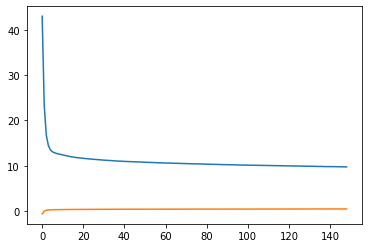

In [37]:
plt.plot(mlp_regressor.loss_curve_)
plt.plot(mlp_regressor.validation_scores_)

With ANNs, you can use `early_stopping` hyperparameter which makes sure that the model stops learning as soon as the accuracy on training set passes that of validation set (set using `validation_fraction`). So we can skip cross_val_score exercise while working with ANNs

In [38]:
param_grid = [{'hidden_layer_sizes': [(500,50), (500,10), (100,10), (10,1)], 
               'tol':[1e-3, 1e-5], 
               'learning_rate_init':[1e-2, 1e-3, 1e-4]}]

grid_search = GridSearchCV(mlp_regressor, param_grid, cv=3,scoring='neg_mean_squared_error',return_train_score=True)

In [39]:
grid_search.fit(X_train_scaled, y_train)

C:\Users\aakulkar\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\aakulkar\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=MLPRegressor(early_stopping=True,
                                    hidden_layer_sizes=(100, 10),
                                    learning_rate='adaptive',
                                    learning_rate_init=0.0005, max_iter=1000,
                                    random_state=42, tol=0.001,
                                    validation_fraction=0.3),
             param_grid=[{'hidden_layer_sizes': [(500, 50), (500, 10),
                                                 (100, 10), (10, 1)],
                          'learning_rate_init': [0.01, 0.001, 0.0001],
                          'tol': [0.001, 1e-05]}],
             return_train_score=True, scoring='neg_mean_squared_error')

Display the scores and parameters for all the 8 models

In [40]:
results = grid_search.cv_results_
for mean_scores, params in zip(results["mean_test_score"], results["params"]):
    print(np.sqrt(-mean_scores), params)

4.254184977783725 {'hidden_layer_sizes': (500, 50), 'learning_rate_init': 0.01, 'tol': 0.001}
4.247793681154332 {'hidden_layer_sizes': (500, 50), 'learning_rate_init': 0.01, 'tol': 1e-05}
4.331615858313142 {'hidden_layer_sizes': (500, 50), 'learning_rate_init': 0.001, 'tol': 0.001}
4.311597642415798 {'hidden_layer_sizes': (500, 50), 'learning_rate_init': 0.001, 'tol': 1e-05}
4.634561527965385 {'hidden_layer_sizes': (500, 50), 'learning_rate_init': 0.0001, 'tol': 0.001}
4.373335504608278 {'hidden_layer_sizes': (500, 50), 'learning_rate_init': 0.0001, 'tol': 1e-05}
4.291371180294632 {'hidden_layer_sizes': (500, 10), 'learning_rate_init': 0.01, 'tol': 0.001}
4.291371180294632 {'hidden_layer_sizes': (500, 10), 'learning_rate_init': 0.01, 'tol': 1e-05}
4.378770396483233 {'hidden_layer_sizes': (500, 10), 'learning_rate_init': 0.001, 'tol': 0.001}
4.346493201543193 {'hidden_layer_sizes': (500, 10), 'learning_rate_init': 0.001, 'tol': 1e-05}
4.825671852980882 {'hidden_layer_sizes': (500, 10), 

Clearly the model with 100 `n_estimators` performs best. Select this model from all the 8 combinations and use it for predictions

In [41]:
best_model = grid_search.best_estimator_
grid_search.best_params_

{'hidden_layer_sizes': (500, 50), 'learning_rate_init': 0.01, 'tol': 1e-05}

As a final step, check the generalization error for the models by using the test set

In [44]:
from sklearn.metrics import r2_score, mean_squared_error
y_pred = best_model.predict(X_test_scaled)

r2_score(y_pred, y_test),np.sqrt(mean_squared_error(y_pred, y_test))

(0.2530671287040055, 4.149914144240132)

In [43]:
X_test_scaled = pipeline.transform(X_test)

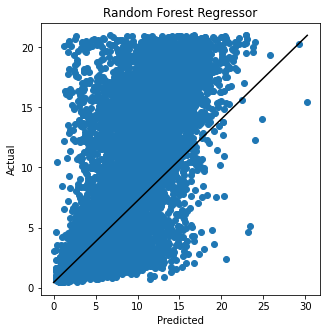

In [45]:
plot_results(X_test_scaled, y_test, best_model, "Random Forest Regressor")

speed vs accuracy - a business decision. at this point do a tradeoff between compute power, time for prediction, model maintenance, updation of model etc

So far, we have walked through the following steps:
* Data Preprocessing:
 * Data visualization - Correlations plots, Bar charts etc.
 * Train test split - Stratified Sampling
 * Scaling - Standard scaling
 * Dimensionality Reduction - PCA with 99% explained variance 
* Model Selection:
 * Linear Model 
 * Random Forest Regressor
 * Artificial Neural Networks
 * GridSearch for better hyperparameters selection
 
Now we need to think about which model to choose between all the ones we analysed. Let us start with comparing the accuracy of each model to begin with:

|Model |Mean RMSE score|Wall Times|
|------|:---------:|-----------:|
|Linear Model| 0.3| 8.7 [ms]
|Random Forest Regressor | 0.3| 25.6 [s]
|Artificial Neural Network (ANN) | 0.3| 23.4 [s]

At this point, we can conclude the following:
* The Linear Regression model is very fast to compute but suffers from low accuracy
* Random Forest Regressor and Artifical Neural Network (ANN) both perform better than Linear Regression model and one of these should be chosen as a suitable model
* The specific model to be chosen for this is a tradeoff between:
 * Speed of prediction **vs** Accuracy
 * Computational resources available at prediction stage **vs** model complexity
 * Model updation considerations
 * Explainability
* We need to adapt the decision based on more information of the deployment platform